In [43]:
import matplotlib.pyplot as plt
import numpy as np
from nexusformat.nexus import nxload
import matplotlib.colors as colors
import matplotlib
from matplotlib.colors import LogNorm
import matplotlib.transforms as mtransforms
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.ticker as ticker

from ase.io import read
%matplotlib inline

# Prepare functions and generate the delta PDF simulation

In [44]:
# Load the files 

ciffilename1 = './c2m.cif'
ciffilename2 = './distort_p1.cif'
struc1 = read(ciffilename1, format="cif")
struc2 = read(ciffilename2, format="cif")



# Get the structural information
pos1 = struc1.get_scaled_positions()
pos2 = struc2.get_scaled_positions()

symbol1 = struc1.get_chemical_symbols()
symbol2 = struc2.get_chemical_symbols()

weights1 = struc1.get_atomic_numbers()
weights2 = struc2.get_atomic_numbers()



# Make list of all difference vectors
veclist1 = []
atomlist1 = []
weightlist1 = []
for ii in np.arange(0,len(pos1)):
    for jj in np.arange(0,len(pos1)):
        veclist1.append( (pos1[ii]-pos1[jj])%1 )        
        atomlist1.append([symbol1[ii], symbol1[jj] ])
        weightlist1.append(weights1[ii]*weights1[jj])
        
veclist2 = []
atomlist2 = []
weightlist2 = []
for ii in np.arange(0,len(pos2)):
    for jj in np.arange(0,len(pos2)):
        veclist2.append( (pos2[ii]-pos2[jj])%1 )        
        atomlist2.append([symbol2[ii], symbol2[jj] ])
        weightlist2.append(weights2[ii]*weights2[jj])
        
# Choose the z and dz values for the cut
z = 0.24
dz = .05



# Change basis to hexagonal unit cell
a = np.array([5.98, 0, 0])
b = np.array([0, 10.357, 0])
c = np.array([np.cos(108.8*np.pi/180), 0, np.sin(108.8*np.pi/180)])*6.014
c2m_orth = np.array([a,b,c]).transpose()

a1 = np.array([5.98, 0, 0])
b1 = 5.98*np.array([np.cos(np.pi*120/180), np.sin(np.pi*120/180), 0])
c1 = np.array([0, 0, 17.05/3])
vol1 = a1.dot(np.cross(b1,c1))
ast = np.cross(b1,c1)/vol1
bst = np.cross(c1,a1)/vol1
cst = np.cross(a1,b1)/vol1
tt = np.array([ast,bst,cst])
metric = tt.dot(tt.transpose())

orth_hex = np.linalg.inv( np.array([a1,b1,c1]).transpose() )

c2m_hex = orth_hex.dot(c2m_orth)
hex_c2m = np.linalg.inv(c2m_hex)
# Make arrays in hexagonal coordinates
pdf_arr = np.zeros([25,25])
x = np.linspace(0,1,25)
y = np.linspace(0,1,25)
xv, yv = np.meshgrid(x,y)
zv = np.zeros([25,25])
# Convert the coordinate arrays to monoclinic coordinates
for t1 in np.arange(0,len(x)):
    for t2 in np.arange(0,len(y)):
        vec = np.array([x[t1], y[t2], z])
        vec = hex_c2m.dot(vec)
        xv[t1,t2] = vec[0]
        yv[t1,t2] = vec[1]
        zv[t1,t1] = vec[2]
        
# Function to place a 3D Gaussian of the appropriate brightness at a given position vec
def place_peak(arr, xarr, yarr, z, vec, weight):
    dist = (xarr-vec[0])**2 + 1.7319**2*(yarr-vec[1])**2 + (z-vec[2])**2
    sigma = 0.03
    arr += weight*np.exp( -dist/2/sigma**2 )
    



# Make the PDF array
for jj in np.arange(0,len(veclist1)):
    vec = veclist1[jj]
    weight = weightlist1[jj]
    zdist = (vec[-1]-z)
    if abs(zdist)<dz:
        place_peak(pdf_arr, xv,yv,z,vec,weight**2)
        place_peak(pdf_arr, xv+1,yv,z,vec,weight**2)
        place_peak(pdf_arr, xv,yv+1,z,vec,weight**2)
        place_peak(pdf_arr, xv+1,yv+1,z,vec,weight**2)
        place_peak(pdf_arr, xv-1,yv,z,vec,weight**2)
        place_peak(pdf_arr, xv-1,yv-1,z,vec,weight**2)
        place_peak(pdf_arr, xv,yv-1,z,vec,weight**2)
        place_peak(pdf_arr, xv+1,yv-1,z,vec,weight**2)
        place_peak(pdf_arr, xv-1,yv+1,z,vec,weight**2)
    vec = -veclist1[jj]
    zdist = (vec[-1]-z)
    if abs(zdist)<dz:
        place_peak(pdf_arr, xv,yv,z,vec,weight**2)
        place_peak(pdf_arr, xv+1,yv,z,vec,weight**2)
        place_peak(pdf_arr, xv,yv+1,z,vec,weight**2)
        place_peak(pdf_arr, xv+1,yv+1,z,vec,weight**2)
        place_peak(pdf_arr, xv-1,yv,z,vec,weight**2)
        place_peak(pdf_arr, xv-1,yv-1,z,vec,weight**2)
        place_peak(pdf_arr, xv,yv-1,z,vec,weight**2)
        place_peak(pdf_arr, xv+1,yv-1,z,vec,weight**2)
        place_peak(pdf_arr, xv-1,yv+1,z,vec,weight**2)
        
pdf_arr2 = np.zeros([25,25])

# Make the PDF array
for jj in np.arange(0,len(veclist2)):
    vec = veclist2[jj]
    weight = weightlist2[jj]
    zdist = (vec[-1]-z)
    if abs(zdist)<dz:
        place_peak(pdf_arr2, xv,yv,z,vec,weight**2)
        place_peak(pdf_arr2, xv+1,yv,z,vec,weight**2)
        place_peak(pdf_arr2, xv,yv+1,z,vec,weight**2)
        place_peak(pdf_arr2, xv+1,yv+1,z,vec,weight**2)
        place_peak(pdf_arr2, xv-1,yv,z,vec,weight**2)
        place_peak(pdf_arr2, xv-1,yv-1,z,vec,weight**2)
        place_peak(pdf_arr2, xv,yv-1,z,vec,weight**2)
        place_peak(pdf_arr2, xv+1,yv-1,z,vec,weight**2)
        place_peak(pdf_arr2, xv-1,yv+1,z,vec,weight**2)
    vec = -vec
    zdist = (vec[-1]-z)
    if abs(zdist)<dz:
        place_peak(pdf_arr2, xv,yv,z,vec,weight**2)
        place_peak(pdf_arr2, xv+1,yv,z,vec,weight**2)
        place_peak(pdf_arr2, xv,yv+1,z,vec,weight**2)
        place_peak(pdf_arr2, xv+1,yv+1,z,vec,weight**2)
        place_peak(pdf_arr2, xv-1,yv,z,vec,weight**2)
        place_peak(pdf_arr2, xv-1,yv-1,z,vec,weight**2)
        place_peak(pdf_arr2, xv,yv-1,z,vec,weight**2)
        place_peak(pdf_arr2, xv+1,yv-1,z,vec,weight**2)
        place_peak(pdf_arr2, xv-1,yv+1,z,vec,weight**2)

# Plot the data and generate the figure

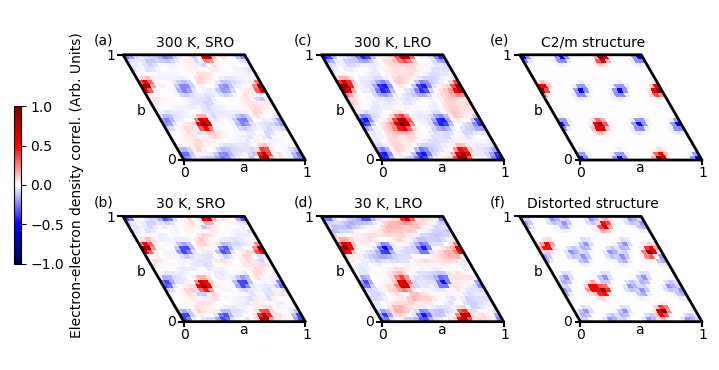

In [45]:
# Compute the deltaPDF for a long range ordered structure with respect to the structure averaged onto a 1/3,1/3 unit cell
# Compare the single layer structure for 30K vs 300K; LRO vs SRO
# Plot in the shape of the unit cell

fig = plt.figure(figsize=(2*(3+3/8)+0.25, 3+3/8+0.125))
ax1 = fig.add_axes([0,0,1,1])
ax1.set_axis_off()

# Choose which cell
x = 6.0
y = 3.0
z = 0.08

# 30K, LRO
datfile = np.load('30_lro_zp08.npz')
xarr = datfile['x']
yarr = datfile['y']
datarr = datfile['arr']
# Make averaged piece
av_arr = np.zeros([9,9])
for xoff in [0,8,16]:
    for yoff in [0,8,16]:
        av_arr += datarr[xoff:xoff+9,yoff:yoff+9]
# Tile averaged piece
tile_av = np.zeros([25,25])
for xoff in [0,8,16]:
    for yoff in [0,8,16]:
        tile_av[xoff:xoff+9,yoff:yoff+9] += av_arr
tile_av[:,8] = tile_av[:,8]/2
tile_av[:,16] = tile_av[:,16]/2
tile_av[8,:] = tile_av[8,:]/2
tile_av[16,:] = tile_av[16,:]/2
delpdf = datarr - tile_av/9
# Plot the 30K LRO pseudo-delPDF
im1 = ax1.pcolormesh(xarr, yarr,  delpdf/np.amax(delpdf), shading='nearest', cmap='seismic')
transf = mtransforms.Affine2D().skew_deg(-26.5651,0).translate(1.7, 0)
trans_data = transf + ax1.transData
im1.set_transform(trans_data)

# 30K, SRO
datfile = np.load('30_sro_zp08.npz')
xarr = datfile['x']
yarr = datfile['y']
sro_dat = datfile['arr']
im2 = ax1.pcolormesh(xarr, yarr,  sro_dat/np.amax(sro_dat), shading='nearest', cmap='seismic')
transf = mtransforms.Affine2D().skew_deg(-26.5651,0).translate(0, 0)
trans_data = transf + ax1.transData
im2.set_transform(trans_data)

# 300K, LRO
datfile = np.load('300_lro_zp08.npz')
xarr = datfile['x']
yarr = datfile['y']
datarr = datfile['arr']
# Make averaged piece
av_arr = np.zeros([9,9])
for xoff in [0,8,16]:
    for yoff in [0,8,16]:
        av_arr += datarr[xoff:xoff+9,yoff:yoff+9]
# Tile averaged piece
tile_av = np.zeros([25,25])
for xoff in [0,8,16]:
    for yoff in [0,8,16]:
        tile_av[xoff:xoff+9,yoff:yoff+9] += av_arr
tile_av[:,8] = tile_av[:,8]/2
tile_av[:,16] = tile_av[:,16]/2
tile_av[8,:] = tile_av[8,:]/2
tile_av[16,:] = tile_av[16,:]/2
delpdf = datarr - tile_av/9
# Plot the 300K LRO pseudo-delPDF
im3 = ax1.pcolormesh(xarr, yarr,  delpdf/np.amax(delpdf), shading='nearest', cmap='seismic')
transf = mtransforms.Affine2D().skew_deg(-26.5651,0).translate(1.7, 1.6)
trans_data = transf + ax1.transData
im3.set_transform(trans_data)

# 300K, SRO
datfile = np.load('300_sro_zp08.npz')
xarr = datfile['x']
yarr = datfile['y']
sro_dat = datfile['arr']
im4 = ax1.pcolormesh(np.array(dat['x']), np.array(dat['y']),  sro_dat/np.amax(sro_dat), shading='nearest', cmap='seismic')
transf = mtransforms.Affine2D().skew_deg(-26.5651,0).translate(0, 1.6)
trans_data = transf + ax1.transData
im4.set_transform(trans_data)

# Simulated data for C2/m (computed in previous cell)
# Make averaged piece
av_arr = np.zeros([9,9])
for xoff in [0,8,16]:
    for yoff in [0,8,16]:
        av_arr += pdf_arr[xoff:xoff+9,yoff:yoff+9]
# Tile averaged piece
tile_av = np.zeros([25,25])
for xoff in [0,8,16]:
    for yoff in [0,8,16]:
        tile_av[xoff:xoff+9,yoff:yoff+9] += av_arr

tile_av[:,8] = tile_av[:,8]/2
tile_av[:,16] = tile_av[:,16]/2
tile_av[8,:] = tile_av[8,:]/2
tile_av[16,:] = tile_av[16,:]/2
pdf_arr = pdf_arr - tile_av/9
im5 = ax1.pcolormesh(np.array(dat['x']), np.array(dat['y']),  pdf_arr/np.amax(pdf_arr), shading='nearest', cmap='seismic')
transf = mtransforms.Affine2D().skew_deg(-26.5651,0).translate(1.7*2, 1.6)
trans_data = transf + ax1.transData
im5.set_transform(trans_data)

# Simulated data for distorted structure (computed in previous cell)
# Make averaged piece
av_arr = np.zeros([9,9])
for xoff in [0,8,16]:
    for yoff in [0,8,16]:
        av_arr += pdf_arr2[xoff:xoff+9,yoff:yoff+9]
# Tile averaged piece
tile_av = np.zeros([25,25])
for xoff in [0,8,16]:
    for yoff in [0,8,16]:
        tile_av[xoff:xoff+9,yoff:yoff+9] += av_arr
tile_av[:,8] = tile_av[:,8]/2
tile_av[:,16] = tile_av[:,16]/2
tile_av[8,:] = tile_av[8,:]/2
tile_av[16,:] = tile_av[16,:]/2
pdf_arr2 = pdf_arr2 - tile_av/9
im6 = ax1.pcolormesh(np.array(dat['x']), np.array(dat['y']),  pdf_arr2/np.amax(pdf_arr2), shading='nearest', cmap='seismic')
transf = mtransforms.Affine2D().skew_deg(-26.5651,0).translate(1.7*2, 0)
trans_data = transf + ax1.transData
im6.set_transform(trans_data)

# Set color limits on meshplots
mval = 1.
im1.set_clim(-mval,mval)
im3.set_clim(-mval,mval)
im2.set_clim(-mval,mval)
im4.set_clim(-mval,mval)
im5.set_clim(-mval,mval)
im6.set_clim(-mval,mval)

# Draw unit cell outlines
x0 = 4.4897
y0 = 4.5792
d = 6
ax1.set_xlim(3,3+d)
ax1.set_ylim(2.6,2.6+d*3**-.5)

def drawcell(x,y,ax):
    dx = 1./24
    off = 0.5 +0.02061
    ax.plot([x,x+1+dx,x+1+dx-off,x-off,x], [y, y, y+1+dx, y+1+dx,y], color='k', lw=2)
    ax.plot([x,x], [y, y-dx], color='k', lw=1.5)
    ax.plot([x+1+dx,x+1+dx], [y, y-dx], color='k', lw=1.5)
    ax.plot([x-dx,x], [y, y], color='k', lw=1.5)
    ax.plot([x-dx-off,x-off], [y+1+dx, y+1+dx], color='k', lw=1.5)
    ax.text(x-0.033,y-4*dx,'0')
    ax.text(x-3.5*dx,y-dx,'0')
    ax.text(x+1+dx-0.027,y-4*dx,'1')
    ax.text(x-3.5*dx-off,y+1-0.01,'1')
    return

drawcell(x0,y0,ax1)
drawcell(x0+1.7,y0,ax1)
drawcell(x0+1.7,y0-1.6,ax1)
drawcell(x0,y0-1.6,ax1)
drawcell(x0+1.7*2,y0-1.6,ax1)
drawcell(x0+1.7*2,y0,ax1)

ax1.text(x0+.47,4.46, 'a')
ax1.text(x0+.47+1.7,4.46, 'a')
ax1.text(x0+.47+1.7,4.26-1.4, 'a')
ax1.text(x0+.47,4.26-1.4, 'a')
ax1.text(x0+.47+1.7*2,4.46, 'a')
ax1.text(x0+.47+1.7*2,4.26-1.4, 'a')

ax1.text(x0-0.4,y0+0.45, 'b')
ax1.text(x0+1.3,y0+0.45, 'b')
ax1.text(x0+1.3,y0-1.15, 'b')
ax1.text(x0-0.4,y0-1.15, 'b')
ax1.text(x0+1.3+1.7,y0+0.45, 'b')
ax1.text(x0+1.3+1.7,y0-1.15, 'b')

# Label subplots 
tt = 0.02
fig.text( 0.1+tt, 0.9, '(a)')
fig.text(0.385+tt, 0.9, '(c)')
fig.text(0.665+tt, 0.9, '(e)')
fig.text( 0.1+tt, 0.44, '(b)')
fig.text(0.385+tt, 0.44, '(d)')
fig.text(0.665+tt, 0.44, '(f)')
x1 = 4.25
ax1.text(x1, 5.7, '300 K, SRO')
ax1.text(x1, 5.5-1.4, '30 K, SRO')
ax1.text(x1+1.7, 5.7, '300 K, LRO')
ax1.text(x1+1.7, 5.5-1.4, '30 K, LRO')
ax1.text(x1+1.7*2-.1, 5.7, 'C2/m structure')
ax1.text(x1+1.7*2-.22, 5.5-1.4, 'Distorted structure')

# Make the colorbar
cbaxes = ax1.inset_axes([0.005, 0.275, 0.01, 0.45] )
cb = fig.colorbar(im1,cax=cbaxes, ticks=[-1.,0,1], orientation='vertical')
cb.set_label('Electron-electron density correl. (Arb. Units)')
cb.set_ticks(ticker.MultipleLocator(0.5))